## Importing Libraries.

In [3]:
library(tidyverse)
library(nflfastR)
library(ggthemes) # Themes for ggplot2.
library(ggimage) # Supports images in ggplot2.
library(gt) # Create tables.
library(readr) # Read in datasets.
options(scipen = 9999)

## Importing PBP Data.

In [4]:
ignore <- c("enforced between downs.")
pbp_raw <- load_pbp(2021) %>%
  filter(season == 2021) %>%
  filter(season_type == "REG") %>%
  filter(play_type != "no_play" | str_detect(desc, paste(ignore, collapse = "|"))) %>% 
  filter(!(str_detect(desc, "enforced between downs.") & str_detect(desc, "Kick formation"))) %>%
  filter(!(str_detect(desc, "enforced between downs.") & str_detect(desc, "No Play.")))
pbp_raw$new_play_num <- ave(pbp_raw$play_id ,pbp_raw$game_id,FUN = seq_along)
pbp_raw <- pbp_raw %>%
  mutate(UNIQUE_PLAY_ID = paste(game_id, new_play_num, sep = "_"))

## Importing Sport Radar Data and Joining Dataframes.

In [5]:
pbp_sportradar <- read_csv(file = "C:/Users/chris/Documents/Datasets/Sportradar NFL/CSV/2021-Sportradar-NFL.csv",
                           show_col_types = FALSE)
pbp_raw <- inner_join(pbp_raw, pbp_sportradar, by = "UNIQUE_PLAY_ID")

## Appending Column for Drive Results. (pts)

In [6]:
pbp_raw <- pbp_raw %>%
  filter(rush == 1 | pass == 1) %>%
  filter(!is.na(epa)) %>%
  mutate(gid_team = paste(game_id, posteam, sep = "-")) %>%
  mutate(yr_team = paste(season, posteam, sep = "-")) %>%
  mutate(drive_id = paste(game_id, posteam, fixed_drive, sep = "-")) %>%
  mutate(drive_res = case_when(
      fixed_drive_result == "End of half" ~ 0,
      fixed_drive_result == "Field goal" ~ 3,
      fixed_drive_result == "Missed field goal" ~ 0,
      fixed_drive_result == "Opp touchdown" ~ -6,
      fixed_drive_result == "Punt" ~ 0,
      fixed_drive_result == "Safety" ~ -2,
      fixed_drive_result == "Touchdown" ~ 6,
      fixed_drive_result == "Turnover" ~ 0,
      fixed_drive_result == "Turnover on downs" ~ 0,
  ))

## Appending Columns for Playcall Type Percentages.

In [7]:
pbp_raw$rushes_game <- ave(pbp_raw$rush, pbp_raw$gid_team, FUN = cumsum)
pbp_raw$passes_game <- ave(pbp_raw$pass, pbp_raw$gid_team, FUN = cumsum)
pbp_raw$rushes_season <- ave(pbp_raw$rush, pbp_raw$yr_team, FUN = cumsum)
pbp_raw$passes_season <- ave(pbp_raw$pass, pbp_raw$yr_team, FUN = cumsum)
pbp_raw$play_action_season <- ave(pbp_raw$PLAY_ACTION, pbp_raw$yr_team, FUN = cumsum)
pbp_raw$rpo_season <- ave(pbp_raw$RPO, pbp_raw$yr_team, FUN = cumsum)
pbp_raw$screen_season <- ave(pbp_raw$SCREEN_PASS, pbp_raw$yr_team, FUN = cumsum)
pbp_raw$season_play_num <- ave(pbp_raw$play_id, pbp_raw$yr_team, FUN = seq_along)

pbp_raw <- pbp_raw %>%
  mutate(run_share_gm = round(rushes_game/(rushes_game + passes_game), 4)) %>%
  mutate(pass_share_gm = round(passes_game/(rushes_game + passes_game), 4)) %>%
  mutate(run_share_szn = round(rushes_season/(rushes_season + passes_season), 4)) %>%
  mutate(pass_share_szn = round(passes_season/(rushes_season + passes_season), 4)) %>%
  mutate(play_action_share_szn = round(play_action_season/(rushes_season + passes_season), 4)) %>%
  mutate(rpo_share_szn = round(rpo_season/(rushes_season + passes_season), 4)) %>%
  mutate(screen_share_szn = round(screen_season/(rushes_season + passes_season), 4))

## Create Table: Playcall Type Percentages by Team.

In [8]:
team_playcalls <- pbp_raw %>%
  group_by(posteam) %>%
  summarize(run_share = round(last(run_share_szn), 3), 
            pass_share = round(last(pass_share_szn), 3), 
            pa_share = round(last(play_action_share_szn), 3), 
            rpo_share = round(last(rpo_share_szn), 3), 
            screen_share = round(last(screen_share_szn), 3)) %>%
  arrange(-screen_share)

## Create Table: Drive Summaries.

In [9]:
drive_summaries <- pbp_raw %>%
  group_by(drive_id) %>%
  summarize(team = last(posteam), start_yardline = first(yardline_100), end_yardline = last(yardline_100), 
            res = last(fixed_drive_result), res_pts = last(drive_res)) %>%
  filter(res != "End of half")

## Create Vector: Points Per Drive by Team.

In [10]:
ppd <- drive_summaries %>%
  group_by(team) %>%
  summarize(pts_per_drive = round(sum(res_pts)/n(), 2)) %>%
  arrange(-pts_per_drive)

## Merge Playcall Type Table and Points Per Drive Vector.

In [86]:
team_off <- merge(team_playcalls, ppd, by.x = "posteam", by.y = "team")

## Add Team Logo Image Column.

In [87]:
team_off <- merge(team_off, teams_colors_logos[,c("team_abbr", "team_wordmark")], by.x = "posteam", by.y = "team_abbr")
team_off <- team_off[,c(8, 7, 3, 4, 5, 6)] %>%
  arrange(-pts_per_drive)

## Create Table: NFL Playcall Rates.

In [88]:
team_off_gt <- team_off %>%
  gt() %>%
  cols_label(team_wordmark = "",
             pts_per_drive = "Points/Drive",
             pass_share = "Pass Rate",
             pa_share = "Play Action Rate",
             rpo_share = "RPO Rate",
             screen_share = "Screen Rate") %>%
  cols_align(align = "center",
             columns = c(pts_per_drive, pass_share, pa_share, rpo_share, screen_share)) %>%
  gtExtras::gt_img_rows(team_wordmark) %>%
  gtExtras::gt_theme_espn() %>%
  tab_header(title = "Playcall Rates by Team, 2021") %>%
  tab_options(heading.title.font.size = 30,
              heading.border.bottom.color = "#808080") %>%
  tab_style(style = cell_borders(sides = "right",
                                 color = "#808080",
                                 weight = px(5)),
            locations = cells_body(columns = c(team_wordmark, pts_per_drive),
                                   rows = everything())) %>%
  tab_style(style = cell_borders(sides = "bottom",
                                 color = "#808080",
                                 weight = px(2)),
            locations = cells_body(columns = everything(),
                                   rows = c(32))) %>%
  tab_style(style = cell_borders(sides = "top",
                                 color = "#808080",
                                 weight = px(2)),
            locations = cells_body(columns = everything(),
                                   rows = 1)) %>%
  data_color(columns = pts_per_drive,
             colors = scales::col_numeric(palette = c("#FEFE69", "#DDF969", "#A9F36A", "#78EC6C", "#57E86B"),
                                          domain = c(1, 3))) %>%
  data_color(columns = pass_share,
             colors = scales::col_numeric(palette = c("#FEFE69", "#DDF969", "#A9F36A", "#78EC6C", "#57E86B"),
                                          domain = c(0.5, 0.7))) %>%
  data_color(columns = pa_share,
             colors = scales::col_numeric(palette = c("#FEFE69", "#DDF969", "#A9F36A", "#78EC6C", "#57E86B"),
                                          domain = c(.05, 0.2))) %>%
  data_color(columns = rpo_share,
             colors = scales::col_numeric(palette = c("#FEFE69", "#DDF969", "#A9F36A", "#78EC6C", "#57E86B"),
                                          domain = c(0.0, 0.3))) %>%
  data_color(columns = screen_share,
             colors = scales::col_numeric(palette = c("#FEFE69", "#DDF969", "#A9F36A", "#78EC6C", "#57E86B"),
                                          domain = c(0.0, 0.1)))

In [94]:
gtsave(team_off_gt, "nfl_playcall_rates.png")

## Create Boxplot Table.

[1] 0.233 0.281 0.016

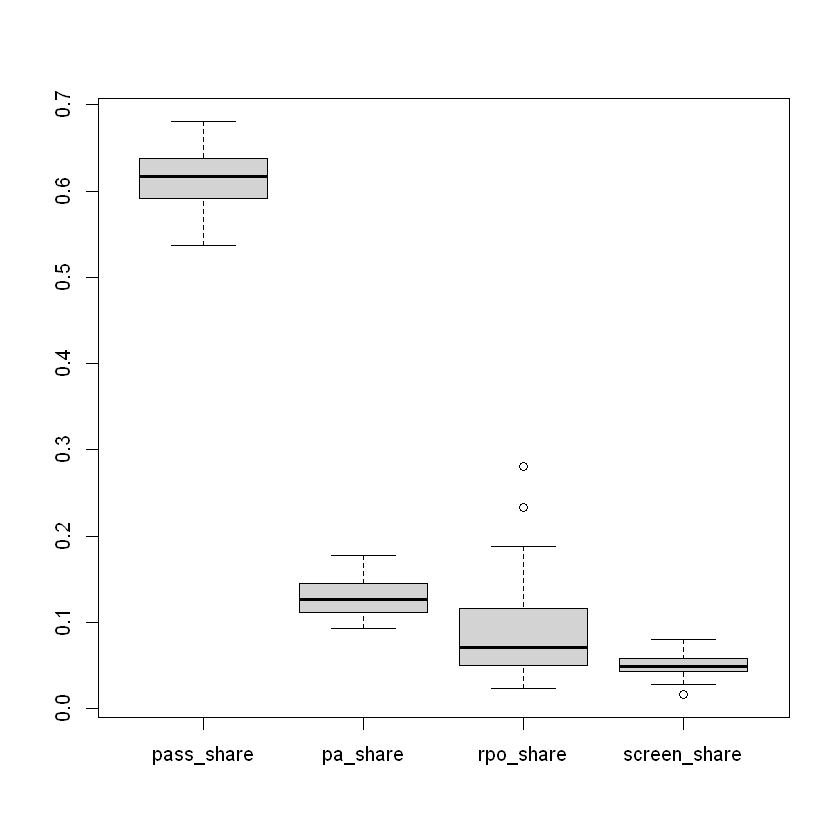

In [91]:
boxplot(team_off[,3:6])$out

## EXTRA: Create Dataset and Perform Regression Analysis.

In [92]:
df <- pbp_raw %>%
  filter(wp > .20, wp < .80, down < 4, half_seconds_remaining > 120, week > 1) %>%
  filter(PLAY_ACTION == 1)

In [93]:
playcall_reg <- lm(pts_per_drive ~ pass_share + pa_share + rpo_share + screen_share, data = team_off)
summary(playcall_reg)


Call:
lm(formula = pts_per_drive ~ pass_share + pa_share + rpo_share + 
    screen_share, data = team_off)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.77900 -0.26725  0.01885  0.29052  0.57988 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)    1.5284     1.2170   1.256    0.220
pass_share    -0.8860     1.8077  -0.490    0.628
pa_share       3.4698     4.2822   0.810    0.425
rpo_share      0.1958     1.3672   0.143    0.887
screen_share   8.5933     5.5836   1.539    0.135

Residual standard error: 0.3897 on 27 degrees of freedom
Multiple R-squared:  0.1262,	Adjusted R-squared:  -0.003275 
F-statistic: 0.9747 on 4 and 27 DF,  p-value: 0.4376
